In [1]:
## Step 2: Trail run to troubleshoot camera linking, finding zeroth order point location, and making sure stuff runs. 
# The biggest challenge here is probably finding the 0th order and making sure the location is stable.
# If we are working in an unstable environment, might be worth using cv2 to find the location of 0th order spot.
# However, there are print lines scattered throughout the code to help pinpoint where things go FUBAR.

import os
from ctypes import *
from scipy import misc
from time import sleep
import cv2
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from instrumental.drivers.cameras import uc480



In [ ]:
#%%%%%%%%%%%%%%%%%%% LOAD MANUFACTURER PROGRAMS AND DLLS- START %%%%%%%%%%%%%%%%%%%%%%%%%

################################ MAKE SURE THE WINDOW SHOWS UP IN THE WRITE PLACE FOR THE DPI SETTINGS#############
# Query DPI Awareness (Windows 10 and 8)
import ctypes
awareness = ctypes.c_int()
errorCode = ctypes.windll.shcore.GetProcessDpiAwareness(0, ctypes.byref(awareness))
print(awareness.value)
# Set DPI Awareness  (Windows 10 and 8)
errorCode = ctypes.windll.shcore.SetProcessDpiAwareness(2)
# the argument is the awareness level, which can be 0, 1 or 2:
# for 1-to-1 pixel control I seem to need it to be non-zero (I'm using level 2)

# Set DPI Awareness  (Windows 7 and Vista)
success = ctypes.windll.user32.SetProcessDPIAware()
# behaviour on later OSes is undefined, although when I run it on my Windows 10 machine, it seems to work with effects identical to SetProcessDpiAwareness(1)
#######################################################################################################################
# Load the DLL
# Blink_C_wrapper.dll, HdmiDisplay.dll, ImageGen.dll, freeglut.dll and glew64.dll
# should all be located in the same directory as the program referencing the
# library
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\Blink_C_wrapper")
slm_lib = CDLL("Blink_C_wrapper")

# Open the image generation library
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\ImageGen")
image_lib = CDLL("ImageGen")
#%%%%%%%%%%%%%%%%%%% LOAD MANUFACTURER PROGRAMS AND DLLS - FIN. %%%%%%%%%%%%%%%%%%%%%%%%%

#%%%%%%%%%%%%%%%%%%% Setup calibration settings %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# init camera
instruments = uc480.list_instruments()
cam = uc480.UC480_Camera(instruments[0])
# Start camera
cam.start_live_video(framerate = "10Hz")

print("Camera Loaded")

RGB = c_uint(1)
is_eight_bit_image = c_uint(0)
slm_lib.Create_SDK(c_uint(1)) # Initialize SDK, c_unit(1) means true
print("Created SDK")

In [2]:
NumDataPoints = 256
NumRegions = 64 ## If we need regional calibration, set this to 64


### numFrames determines how many times we will take a picture of a set diffraction grating. I recommend 3~5 to get a good average. 
numFrames = 1
height = c_uint(slm_lib.Get_Height())
width = c_uint(slm_lib.Get_Width())
depth = c_uint(slm_lib.Get_Depth())
center_x = c_uint(width.value//2)
center_y = c_uint(height.value//2)

success = 0
success = slm_lib.Load_lut("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\LUT Files\\19x12_8bit_linearVoltage.lut")
print("Load LUT success")
#these arrays hold our data points. 
Image = np.empty([width.value*height.value*3], np.uint8, 'C')
WFC = np.zeros([width.value*height.value*3], np.uint8, 'C')
AI_Intensities = np.zeros([NumDataPoints], np.float32, 'C')
image_lib.Generate_Solid(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, c_uint(0), RGB)
print("Generate Image success")
slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), c_uint(1))
print("Write Image success")

PixelValueOne = c_uint(255)
PixelsPerStripe = c_uint(4)
#the loops are a bit redundant, but let's keep them just in case we want to do regional calibrations later.


Load LUT success
Generate Image success
Write Image success


In [4]:
for region in range(0,NumRegions,1):
    region = 3
    print("Region: %d\n", region)
    for gray in range(0,NumDataPoints,1):
        print("Gray: %d\r", gray)
        PixelValueTwo = c_uint(255-gray)
        image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
        image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
        slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
        sleep(0.05)
        net = 0
        for frames in range(0, numFrames, 1):
            #Important: exposure_time can be set to your liking, choose one that's best for saturation
            frame = cam.grab_image(timeout='100s', copy=True, exposure_time='3ms')
            numpix = 0 
            #this region has to be handled by you!!! Find the region where the 0th order / 1st order spot is
            #You can average over nearby pixels, take the max value, or something else. 
            #You can find where the desired spot is by passing a diffraction grating to the SLM manually and opening the Thorlabs camera in Python. Then translate camera to an array, find points on array, and put in coords. Code for this should be available above.
            net = np.max(frame[200:600, 600:1000])
        AI_Intensities[gray] = net
        print(net)
        # this will give you an indicator of your pixel values. make sure there's no over/under saturation!

print(AI_Intensities)

Region: %d
 3
 0ay: %d
2
 1ay: %d
2
 2ay: %d
2
 3ay: %d
2
 4ay: %d
2
 5ay: %d
3
 6ay: %d
3
 7ay: %d
4
 8ay: %d
5
 9ay: %d
6
 10y: %d
7
 11y: %d
8
 12y: %d
10
 13y: %d
11
 14y: %d
12
 15y: %d
15
 16y: %d
18
 17y: %d
19
 18y: %d
21
 19y: %d
21
 20y: %d
24
 21y: %d
28
 22y: %d
31
 23y: %d
34
 24y: %d
36
 25y: %d
40
 26y: %d
41
 27y: %d
45
 28y: %d
48
 29y: %d
53
 30y: %d
56
 31y: %d
59
 32y: %d
63
 33y: %d
66
 34y: %d
69
 35y: %d
75
 36y: %d
79
 37y: %d
84
 38y: %d
89
 39y: %d
92
 40y: %d
95
 41y: %d
101
 42y: %d
105
 43y: %d
109
 44y: %d
115
 45y: %d
120
 46y: %d
123
 47y: %d
130
 48y: %d
131
 49y: %d
139
 50y: %d
142
 51y: %d
146
 52y: %d
148
 53y: %d
155
 54y: %d
156
 55y: %d
164
 56y: %d
163
 57y: %d
171
 58y: %d
174
 59y: %d
176
 60y: %d
173
 61y: %d
182
 62y: %d
182
 63y: %d
187
 64y: %d
183
 65y: %d
189
 66y: %d
187
 67y: %d
190
 68y: %d
188
 69y: %d
191
 70y: %d
186
 71y: %d
187
 72y: %d
183
 73y: %d
184
 74y: %d
177
 75y: %d
180
 76y: %d
170
 77y: %d
169
 78y: %d
160
 79y: %d
159

KeyboardInterrupt: 

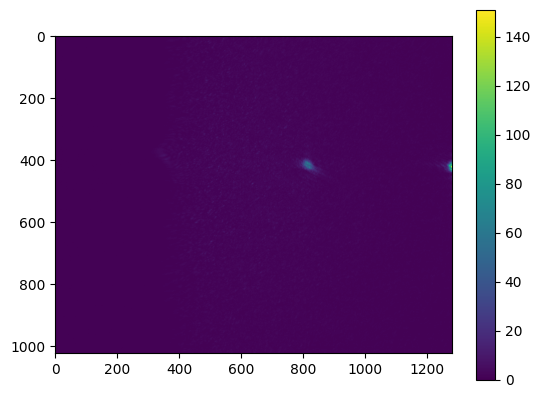

In [4]:
image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, c_uint(4), PixelsPerStripe, RGB)
image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
sleep(0.03)
frame = cam.grab_image(timeout='100s', copy=True, exposure_time='30ms')
# plt.imshow(frame[505:515, 587:627])
plt.imshow(frame)

plt.colorbar()

In [6]:
### Step 3: Get your intensity values!
# once you find the location, let's run that loop once more. Note that the camera should still be open, the SLM
# should still be initialized, and we are good to go. IF stuff doesn't run, just try restarting the notebook and running cells from
# top to bottom. For some reason the SLM's shutdown function doesn't work(?) so I've just been restarting the notebook to
# close the SLM. 
NumDataPoints = 256
PixelValueOne = c_uint(255)
PixelsPerStripe = c_uint(4)
NumRegions = 64
AI_Intensities = np.zeros([NumRegions,NumDataPoints], np.float32, 'C')

Regions_Of_Interest = [29,34,42,49,54,60]
for region in Regions_Of_Interest:
    print("Region: %d\n", region)
    for gray in range(0,NumDataPoints,1):
        PixelValueTwo = c_uint(255-gray)
        image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
        image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
        slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
        # set a 30ms delay to let SLM settle.
        sleep(0.03)
        net = 0
        ##net = np.sum(map[509:512,644:647])
        time = '2.7ms'
        map = cam.grab_image(timeout='100s', copy=True, exposure_time = time)
        #change map[] to desired coordinates of spot. 
        net = np.max(map[200:600, 600:1000]) +net
        
        map = cam.grab_image(timeout='100s', copy=True, exposure_time = time)
        #change map[] to desired coordinates of spot. 
        net = np.max(map[200:600, 600:1000]) +net
        
        net = net / 2
        AI_Intensities[region, gray] = net
        print(net)
## Again, make sure there's no over/undersaturation. If there is, it's time to adjust exposure time or dark lens.
print(AI_Intensities)

Region: %d
 29
3.0
3.0
3.0
3.0
3.0
3.0
4.0
5.0
5.0
6.5
7.5
9.0
10.5
12.0
13.0
17.5
20.0
22.5
24.5
24.5
27.0
34.0
37.5
41.0
45.0
49.0
53.0
56.0
61.0
66.5
69.5
74.5
80.0
85.5
90.5
95.5
102.5
107.5
114.5
116.5
123.5
129.5
137.0
144.5
149.0
154.0
160.5
164.5
172.0
175.5
183.0
186.5
191.5
199.0
203.5
206.5
208.5
215.5
215.5
217.0
219.5
219.0
221.5
221.5
221.0
220.0
218.5
216.5
216.0
215.0
211.0
208.5
208.5
204.0
198.0
193.5
190.5
184.5
179.0
171.0
167.5
162.5
155.0
148.5
141.0
136.0
127.5
118.0
112.0
105.5
98.0
90.5
83.0
75.0
70.0
63.5
55.0
49.0
42.5
37.0
32.0
27.5
22.5
18.5
14.0
11.0
9.0
7.0
5.5
5.0
5.0
6.0
8.0
10.5
14.0
18.0
24.5
29.5
37.0
45.0
54.0
62.5
73.0
83.0
95.5
106.0
118.5
129.5
144.5
153.0
166.5
178.0
191.5
198.5
206.5
218.0
223.0
230.0
235.0
239.5
242.5
244.0
243.5
241.5
241.0
237.5
232.5
229.5
226.0
217.5
213.5
205.5
194.0
191.5
179.0
172.0
164.0
150.0
147.0
135.5
129.0
117.0
105.0
95.5
88.0
81.0
72.5
64.5
57.0
51.0
43.0
37.5
31.5
26.5
21.0
17.5
13.5
10.5
7.5
5.5
4.5
3.0
3.0
3.

In [9]:
AI_Intensities[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [18]:
import pandas as pd
df = np.array(pd.read_csv('regionto29.txt', header=None))

# Assuming you have a zeros array
zeros_array = np.zeros((64, 256))

 

In [103]:
data_array = np.genfromtxt('MergedGlobalNormalizedMeasurements.csv', delimiter=',', filling_values=0)[:,1:65].T * 255


In [104]:
colnum = 0
zerosrownum = 0
buffer = 0
for rownum in range(len(df)):
    if buffer > 0:
        buffer -= 1
        continue
    if 'Region' in str(df[rownum]):
        colnum = int(df[rownum+1])
        zerosrownum = 0
        buffer += 1
        continue
    data_array[colnum, zerosrownum] = df[rownum]
    zerosrownum += 1


    

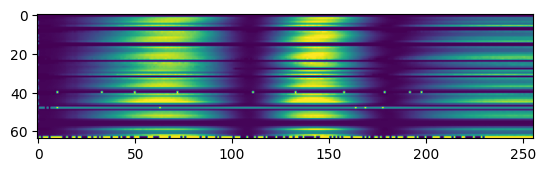

In [113]:
plt.imshow(data_array)

In [110]:
for i in range(0,64,1):
    Row_i = data_array[i].flatten()
    numbers = np.arange(256)
    csvdat_i = np.stack((numbers, Row_i), axis=1)
    np.savetxt(f'Raw{i}.csv',csvdat_i, delimiter = ",", fmt='%d')


In [112]:

np.savez_compressed("rawnew.npz", array1=data_array)

In [7]:
np.shape(AI_Intensities)

(64, 256)

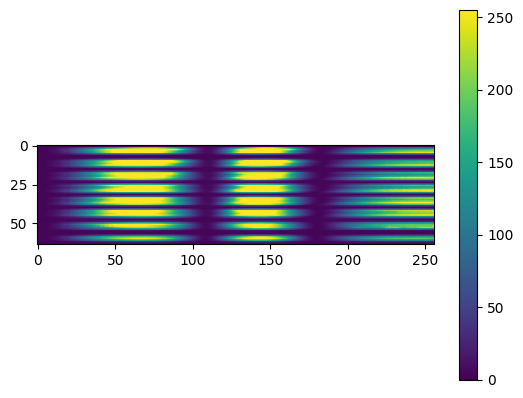

In [12]:
plt.imshow(AI_Intensities)
plt.colorbar()

In [19]:
AI_Intensities[2].flatten()

array([  3.,   3.,   3.,   3.,   3.,   3.,   4.,   5.,   5.,   7.,   8.,
         9.,  10.,  11.,  14.,  17.,  19.,  20.,  23.,  22.,  26.,  30.,
        34.,  36.,  39.,  42.,  46.,  49.,  51.,  55.,  59.,  64.,  66.,
        72.,  80.,  82.,  84.,  90.,  92.,  96., 103., 109., 114., 120.,
       128., 132., 134., 136., 144., 151., 157., 160., 162., 171., 174.,
       181., 188., 190., 194., 202., 200., 210., 211., 212., 214., 216.,
       218., 223., 226., 224., 224., 228., 224., 226., 223., 224., 225.,
       222., 217., 211., 208., 203., 201., 190., 180., 173., 167., 163.,
       153., 148., 139., 125., 115., 108.,  97.,  88.,  81.,  74.,  63.,
        54.,  48.,  42.,  32.,  27.,  22.,  18.,  14.,  11.,   8.,   6.,
         6.,   7.,   8.,   9.,  12.,  16.,  21.,  26.,  31.,  37.,  45.,
        54.,  60.,  67.,  77.,  88.,  95., 105., 117., 123., 139., 149.,
       160., 170., 185., 191., 201., 206., 216., 221., 231., 241., 241.,
       246., 249., 253., 255., 255., 255., 255., 25